In [16]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime,date
import plotly.express as px
import myfunction as mf
#Define some lists/arrays
depth = np.array([0.02, 0.04, 0.06, 0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14,2.39,4.676,7.635,11.140,15.115])
node_z = [0.01,0.04,0.09,0.16,0.26,0.40,0.587,0.80,1.06,1.36,1.70,2.08,2.50,2.99,3.58,4.27,5.06,5.95,6.94,8.03,9.795,13.328,19.483,28.871,41.998]
sec_pr_day=60*60*24
depth_30=np.array([0.02,0.04,0.06,0.08,0.10]) #layer depths to multiply with concentrations
depth_50=np.array([0.02,0.04,0.06,0.08,0.12,0.16,0.02]) #[meters]

C_pool_names   =  ['LITm', 'LITs', 'SAPb', 'SAPf', 'EcM','AM', 'SOMp', 'SOMa', 'SOMc']
N_pool_names =  ['N_LITm', 'N_LITs', 'N_SAPb', 'N_SAPf', 'N_EcM', 'N_AM','N_SOMp', 'N_SOMa', 'N_SOMc', 'N_NH4_sol','N_NH4_sorp','N_NO3']

PFT_names=["not_vegetated                           ",
    "needleleaf_evergreen_temperate_tree     ",
    "needleleaf_evergreen_boreal_tree        ",
    "needleleaf_deciduous_boreal_tree        ",
    "broadleaf_evergreen_tropical_tree       ",
    "broadleaf_evergreen_temperate_tree      ",
    "broadleaf_deciduous_tropical_tree       ",
    "broadleaf_deciduous_temperate_tree      ",
    "broadleaf_deciduous_boreal_tree         ",
    "broadleaf_evergreen_shrub               ",
    "broadleaf_deciduous_temperate_shrub     ",
    "broadleaf_deciduous_boreal_shrub        ",
    "c3_arctic_grass                         ",
    "c3_non-arctic_grass                     ",
    "c4_grass                                ",]
PFT_names=[i.strip() for i in PFT_names]

temp_colors =["blue","purple","red"]
prec_colors = ["goldenrod","lightseagreen","darkblue"]

In [17]:
#COPY THIS TO NOTEBOOK, THE globals() THING DOES NOT WORK FROM HERE. 
def import_decomp(dir_list,file_ext,date_bool):
    site_data=[]
    decomp_names=[]
    dirs = dir_list
    path_of_the_directory = '/home/elisacw/soil_decomp/results/'

    for folder in dirs:
        ext = (folder+file_ext)
        for files in os.listdir(path_of_the_directory+folder):
            if files.endswith(ext):
                filename = os.fsdecode(files)  
                name = filename[:-len(ext)-1]
                if name[0:2] != 'NR':
                    name='NR'+name#+folder
                else:
                    name = name #+folder
                decomp_names.append(name)
                globals()[name+"_"+folder+file_ext[0:-3]] = xr.load_dataset(path_of_the_directory+folder+"/"+filename)

                globals()[name+"_"+folder+file_ext[0:-3]].attrs['site_name'] = name
                globals()[name+"_"+folder+file_ext[0:-3]].attrs['run_name'] = folder
                if date_bool:
                    mf.add_date_dim(globals()[name+"_"+folder+file_ext[0:-3]])

                site_data.append(globals()[name+"_"+folder+file_ext[0:-3]])
            else:
                continue
        site_data =  sorted(site_data,key=lambda x: x.site_name)
        decomp_names = sorted(decomp_names)
        #decomp_names: list of name strings
        #site_data: list of xarrays
    return decomp_names,site_data

In [18]:
def plot_depths_vr(data, pool_list,plot_title):

    fig = plt.figure(figsize=(25, 5*len(data.levsoi)))
    fig.suptitle(plot_title, fontsize=18, y=.90)
    for i in range(len(data.levsoi)):
        ax = fig.add_subplot(len(data.levsoi), 1, i+1)
        ax.set_title("Layer nr: %i" % i, fontsize=14)
        for p in range(len(pool_list)):
            pool_mass = data[pool_list[p]][i]*depth[i]
            plt.plot(data.time, pool_mass, label='%s' % pool_list[p])
            plt.legend()
            plt.grid(True)
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# This one does not plot the total mass!


def plot_pools_vr(data, pool_list, plot_title):

    fig = plt.figure(figsize=(25, 5*len(pool_list)))
    fig.suptitle(plot_title, fontsize=18, y=.92)

    for p in range(len(pool_list)):
        ax = fig.add_subplot(len(pool_list), 1, p+1)
        ax.set_title(pool_list[p], fontsize=14)
        for i in range(len(data.levsoi)):
            pool_mass = data[pool_list[p]][i]*depth[i]
            plt.plot(data.time, pool_mass, label='Layer nr: %i' % (i+1))
            plt.legend()
            plt.grid(True)



In [19]:
def add_date_dim(data):  # data: xarray dataset

    to_int = data.mcdate.astype('int')

    to_str = to_int.astype('str')

    dates_list = [datetime.strptime(date, '%Y%m%d')
                  for date in list(to_str.values)]

    data.coords["time"] = dates_list

    return data

### Import spinup file and Inspect it:

In [20]:
#Load dataset as xarray:
spinup_ds = xr.load_dataset("/home/elisacw/soil_decomp/results/equal_input/31464_Hurdal_equal_input_Spunup_yearly_mean.nc") #change path if needed

spinup_ds

<xarray.Dataset>
Dimensions:           (levsoi: 8, time: 1000)
Dimensions without coordinates: levsoi, time
Data variables: (12/23)
    LITm              (levsoi, time) float32 615.3 1.063e+03 ... 16.6 16.75
    N_LITm            (levsoi, time) float32 32.3 39.19 45.11 ... 0.3865 0.3909
    LITs              (levsoi, time) float32 2.622e+03 5.404e+03 ... 103.1 103.4
    N_LITs            (levsoi, time) float32 41.1 59.88 76.67 ... 1.599 1.601
    SAPb              (levsoi, time) float32 14.06 1.041 0.09159 ... 18.64 18.0
    N_SAPb            (levsoi, time) float32 2.812 0.2083 0.01832 ... 3.728 3.6
    ...                ...
    N_SOMc            (levsoi, time) float32 93.79 112.6 128.8 ... 34.22 34.22
    N_NH4_sol         (levsoi, time) float32 0.08808 0.1767 ... 0.0528 0.07189
    N_NH4_sorp        (levsoi, time) float32 9.918 9.937 10.02 ... 16.6 16.6
    N_NO3             (levsoi, time) float32 1.418 0.02303 ... 1.193 1.548
    HR_flux           (time) float32 0.002322 0.003491 ... 0.07447 0.05513
    year_since_start  (time) float32 1.0 2.0 3.0 4.0 ... 997.0 998.0 999.0 1e+03

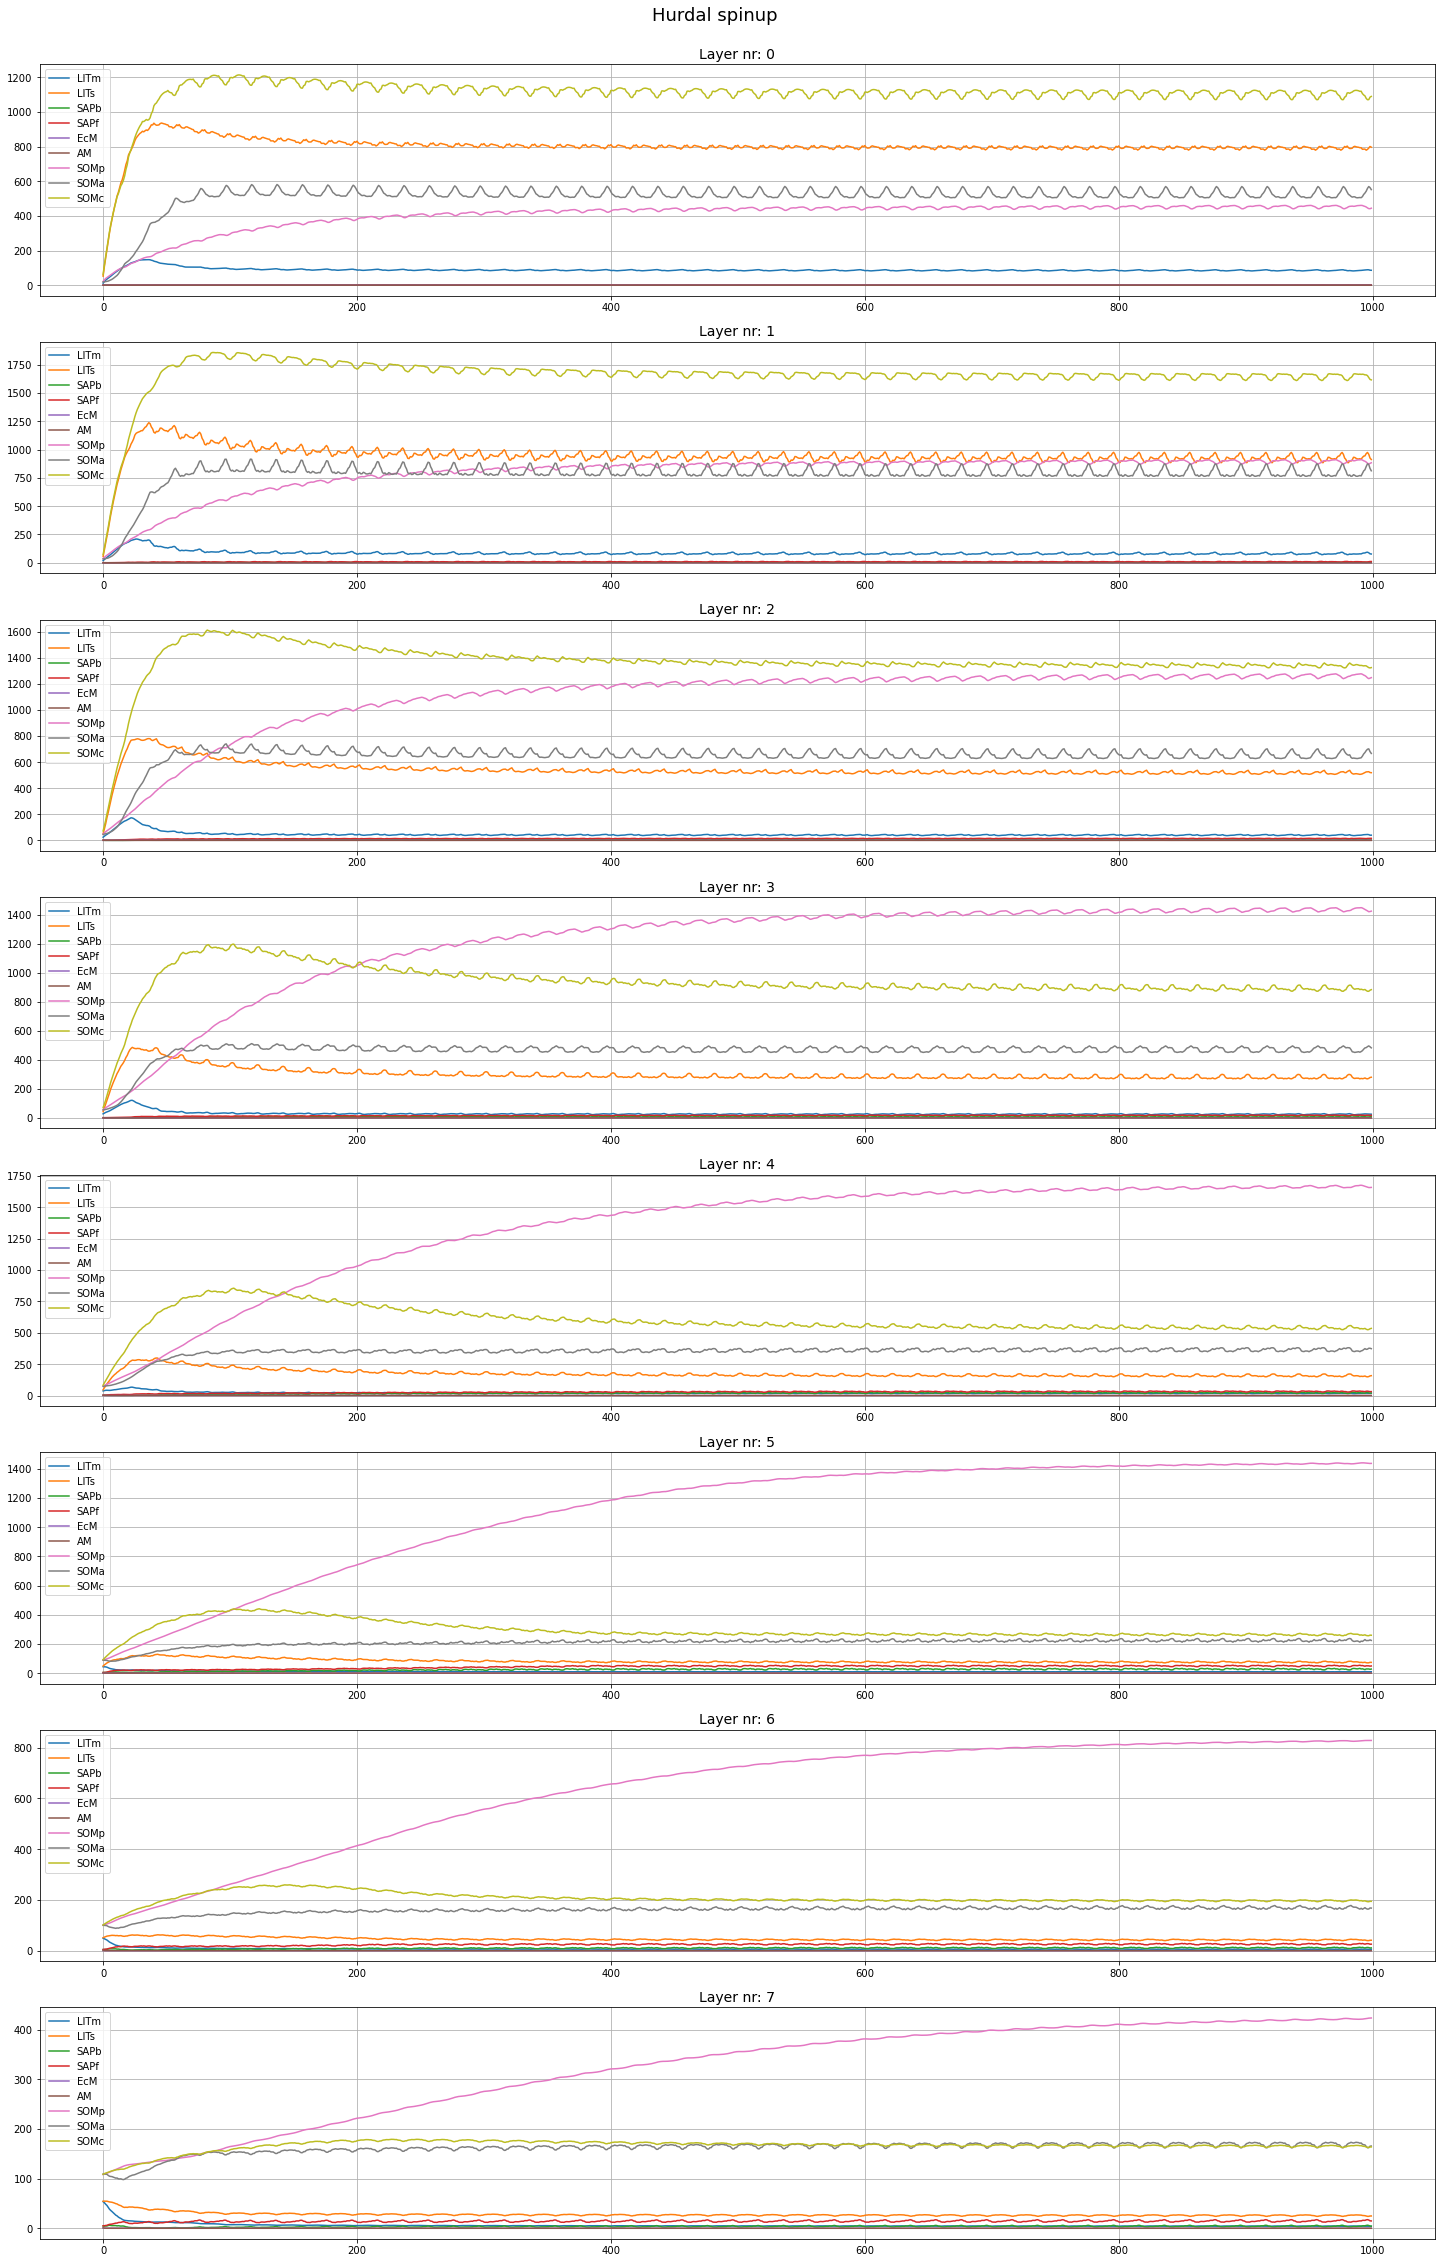

In [21]:
#Plot each layer of each pool of C
plot_depths_vr(spinup_ds,C_pool_names,"Hurdal spinup")

In [22]:
spinup_ds1 = xr.load_dataset("/home/elisacw/soil_decomp/results/equal_input/langtjern_equal_input_Spunup.nc") #change path if needed

spinup_ds1

<xarray.Dataset>
Dimensions:              (levsoi: 8, time: 10, NoMMKeqs: 6, SAPpools: 2)
Coordinates:
  * time                 (time) int32 1 878400 1756800 ... 7027200 7905600
Dimensions without coordinates: levsoi, NoMMKeqs, SAPpools
Data variables: (12/139)
    LITm                 (levsoi, time) float32 452.4 4.759e+03 ... 18.87 18.83
    vert_changeLITm      (levsoi, time) float32 0.0 -0.04823 ... 3.396e-06
    N_LITm               (levsoi, time) float32 30.16 77.12 ... 0.444 0.4432
    N_vert_changeLITm    (levsoi, time) float32 0.0 -0.0007556 ... 8.039e-08
    LITs                 (levsoi, time) float32 452.4 4.358e+04 ... 109.3 109.2
    vert_changeLITs      (levsoi, time) float32 0.0 -0.3415 ... 2.527e-05
    ...                   ...
    desorp               float32 7.95e-07
    k_sapsom             (SAPpools) float32 5.994e-05 2.516e-05
    f_phys               (SAPpools) float32 0.3916 0.2356
    f_avail              (SAPpools) float32 0.5843 0.692
    f_chem               (SAPpools) float32 0.02413 0.0724
    depth                float32 0.92

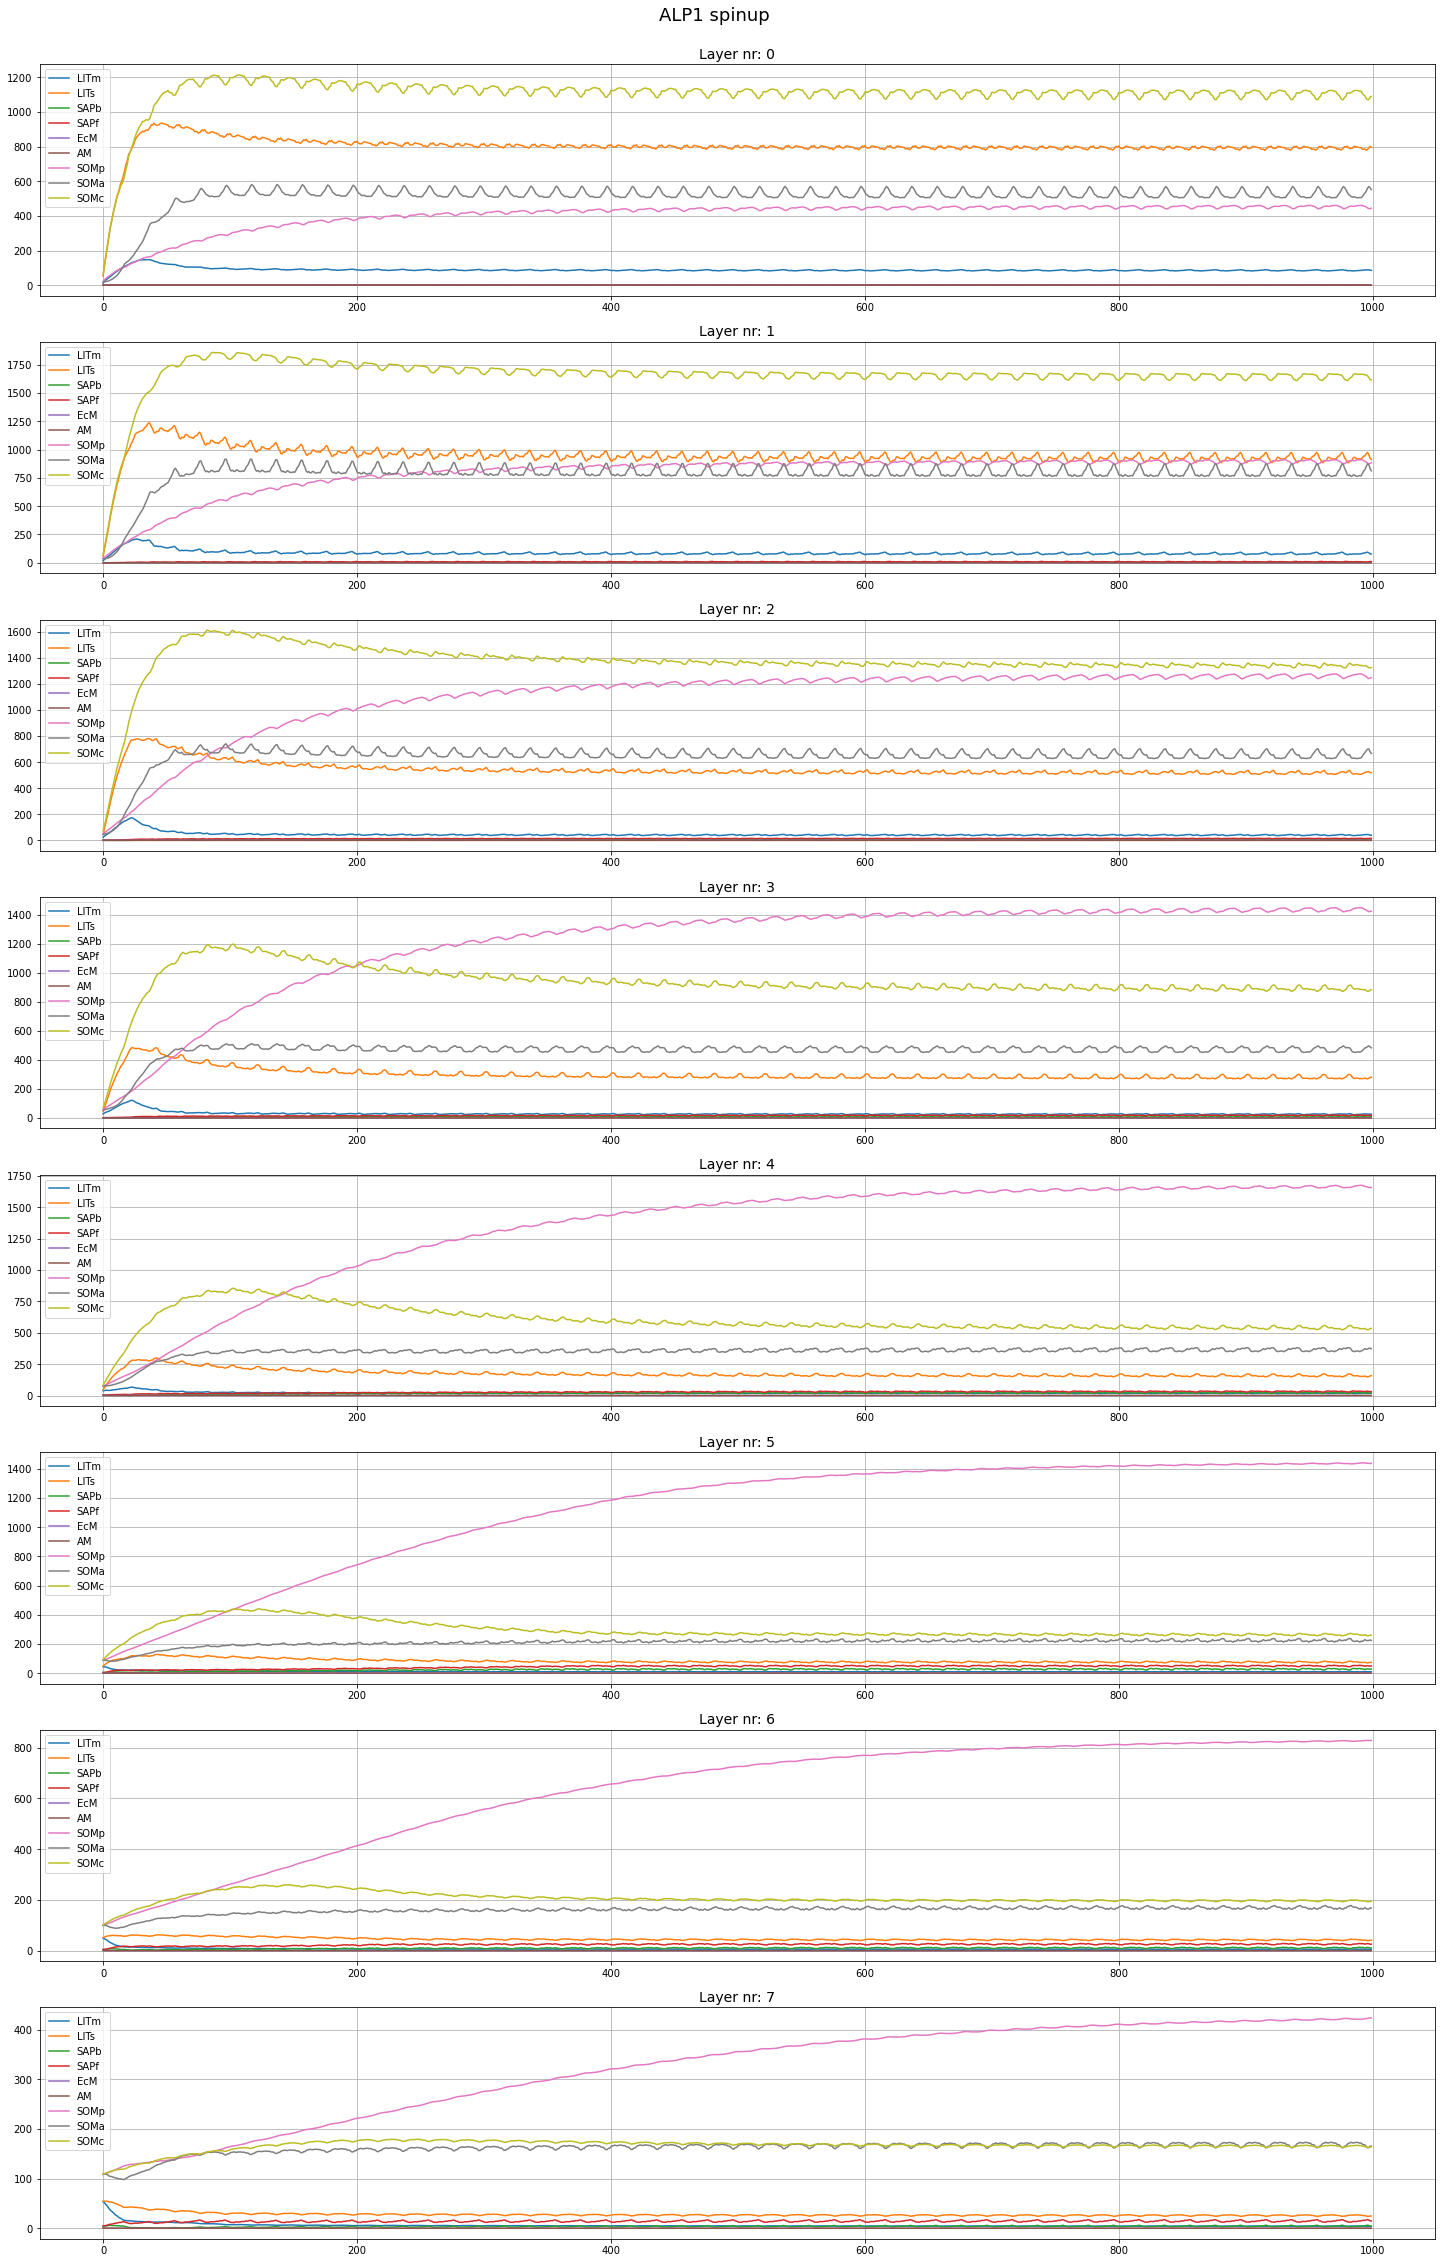

In [23]:
#Plot each pool in each layer of C
plot_depths_vr(spinup_ds,C_pool_names,"ALP1 spinup")

### Look at time period 1988-1992

In [26]:
hist_ds = xr.load_dataset("/home/elisacw/soil_decomp/results/test_Hurdal/31464_Hurdal_test_Hurdal_to2014.nc")
add_date_dim(hist_ds)
hist_ds

FileNotFoundError: [Errno 2] No such file or directory: b'/home/elisacw/soil_decomp/results/test_Hurdal/31464_Hurdal_test_Hurdal_to2014.nc'

In [25]:
def plot_seasonal_mass_and_conc_carbon(data, title):
    month_length = data.time.dt.days_in_month
    weights = (month_length.groupby("time.season") /
               month_length.groupby("time.season").sum())
    weighted_season_mean = (
        weights*data).groupby("time.season").sum(dim="time")

    # Use to convert from gC/m3 to gC/m2
    active_depths = xr.DataArray(depth[:len(data.levsoi)], dims="levsoi")
    weighted_season_mean_mass = weighted_season_mean*active_depths

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Mass of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m2]")
        plt.ylabel("Depth [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean_mass[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean_mass.levsoi)], 
                    '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Concentration of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m3]")
        plt.ylabel(" [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean.levsoi)],
                 '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()


In [ ]:
plot_seasonal_mass_and_conc_carbon(hist_ds,"Hurdal 1988-1992")